## **Netflix Movie Clustering**

In this notebook we try to cluster netflix shows into various categories based on their description. We use K means clustering along with various text encoding techniques to find the the optimum number of separable clusters. 
The main metric used to evaluate a cluster is silhoutte score.

The following steps have been performed



1.   Importing Libraries
2.   Loading the Dataset
3.   Data cleaning and subsetting
4.   Data Visualizations 
5.   Text Preprocessing
6.   Implementing K means clustering using TF-IDF vectorization
7.   Tuning K Value 
8.   Validating results
9.   Implementing K means clustering using Doc2Vec word embedding
10.  Tuning K value
11.  Validaing results
12.  Implementing K means clustering using Auto Encoder word embedding
13.  Tuning K value
14.  Validaing results




### **Importing Libraries **

In [5]:
# Basic Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import itertools as it
from collections import Counter

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('stopwords')
stop = stopwords.words('english')

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn libraries
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


#tensorflow libraries

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.preprocessing import sequence



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **Loading Dataset**

In [6]:

netflix_titles = pd.read_csv("netflix_titles.csv")
print("Shape of the dataset: ",netflix_titles.shape)
netflix_titles.head()

Shape of the dataset:  (8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


### **Data Cleaning and Subsetting**

In [7]:
print("Checking for duplicates \n")
print("Number of unique titles:",netflix_titles['title'].nunique())
print("Number of unique show Id:",netflix_titles['show_id'].nunique())
print("\n")

print("Checking for Nulls \n")
print(netflix_titles.isnull().sum())

#netflix_titles = netflix_titles[['show_id','title','description']]

Checking for duplicates 

Number of unique titles: 8807
Number of unique show Id: 8807


Checking for Nulls 

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64


### **Data Visualization**

Text(0, 0.5, 'Ratio')

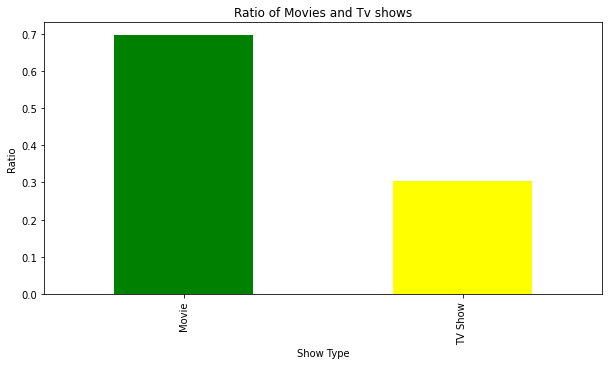

In [8]:
movie_perc = netflix_titles['type'].value_counts()/netflix_titles.shape[0]
plot1 = movie_perc.plot.bar(color = ['green','yellow'],figsize = (10,5))
plt.title("Ratio of Movies and Tv shows")
plt.xlabel("Show Type")
plt.ylabel("Ratio")


Text(0, 0.5, 'Number of shows')

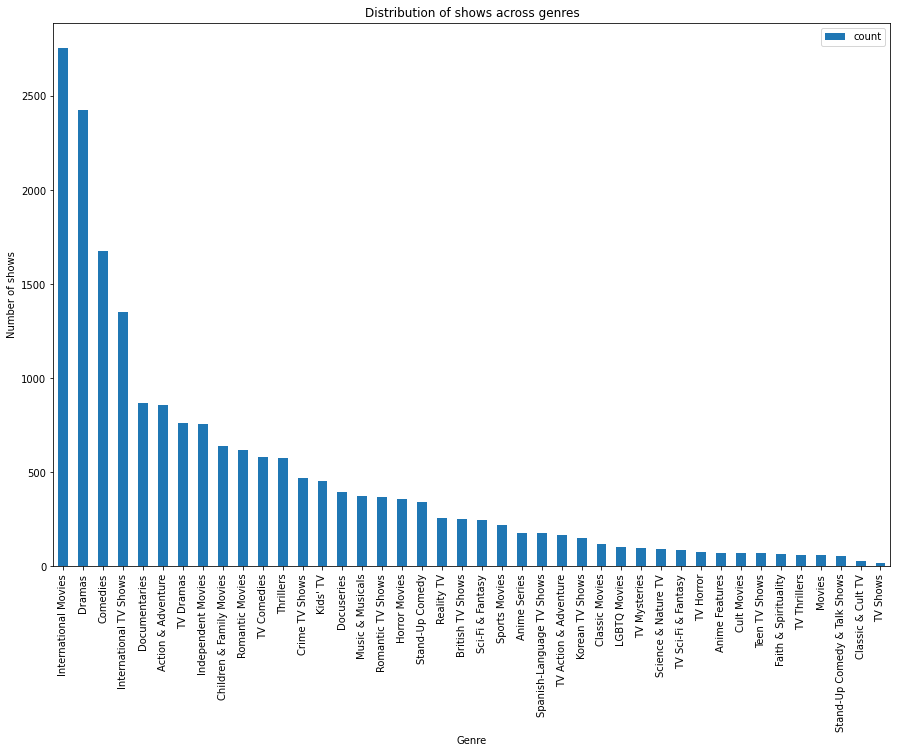

In [9]:
genres = netflix_titles['listed_in']
genres = [x.split(', ') for x in genres]
genres_count = Counter(it.chain(*map(set, genres)))
genres_df = pd.DataFrame.from_dict(genres_count,orient='index').reset_index()
genres_df.columns = ['genres','count']
genres_df.sort_values(['count'],inplace = True,ascending = False)
genres_df.plot.bar(x = 'genres',y='count',figsize =(15,10) )
plt.title("Distribution of shows across genres")
plt.xlabel("Genre")
plt.ylabel("Number of shows")


### **Text Preprocessing**

In [10]:
netflix_titles['description'] = netflix_titles['description'].str.strip()
netflix_titles['description'] = netflix_titles['description'].str.lower()
netflix_titles['description'] = netflix_titles['description'].str.replace('[^a-zA-Z]', ' ',)
netflix_titles['description'] = netflix_titles['description'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split() if word not in (stop)]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


### Implementing K means clustering using TF-IDF vectorizer for feature extraction


In [11]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(netflix_titles['description'])
print("Shape of input vector after TF-IDF is applied:", X.shape)


Shape of input vector after TF-IDF is applied: (8807, 16675)


### Tuning K Value

In [12]:
sil = []
maxRange = 50
iner = []
for i in range(2,maxRange):
    model = KMeans(n_clusters=i, random_state=10)
    cluster_labels = model.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    inertia = model.inertia_
    sil.append(silhouette_avg)
    iner.append(inertia)


### **Plotting the WCSS for the various clusters**

Text(0, 0.5, 'WCSS')

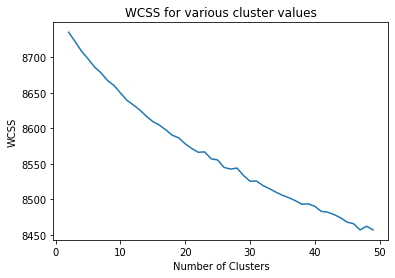

In [13]:
plt.plot(list(range(2,maxRange)),iner)
plt.title("WCSS for various cluster values")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")


### **Plotting the silhoutte scores for the various clusters**

Text(0, 0.5, 'Silhoutte Score')

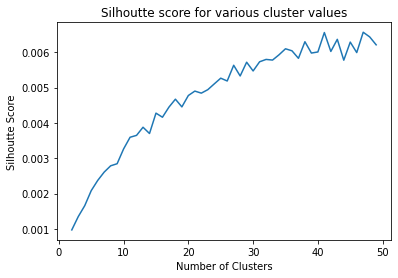

In [14]:
plt.plot(list(range(2,maxRange)),sil)
plt.title("Silhoutte score for various cluster values")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhoutte Score")


In [15]:

model = KMeans(n_clusters=38, random_state=10)
cluster_labels = model.fit_predict(X)
silhouette_avg = silhouette_score(X, cluster_labels)
print("Silhoutte Score: ",silhouette_avg)
netflix_titles['cluster'] = cluster_labels


Silhoutte Score:  0.006294434308040728


In [16]:
#Checking Cluster distribution
netflix_titles['cluster'].value_counts()

0     1995
27     448
18     338
36     328
32     307
3      303
20     300
37     285
15     261
34     247
22     237
8      235
24     213
16     191
11     179
4      171
10     170
2      164
9      154
5      153
12     148
13     147
21     147
29     144
31     144
17     135
28     129
7      128
25     124
26     123
6      111
30     101
35     100
33      97
19      96
14      89
1       84
23      81
Name: cluster, dtype: int64

### **Implementing K means clustering using Doc2Vec Word Embedding**

In [17]:
#Creating Doc2Vec embeddings

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(list(netflix_titles['description']))]
model = Doc2Vec(documents, size=300,dm = 1, workers=10)

X=[model.docvecs[i] for i in range(len(documents))]
print("Size of input vector after Doc2Vec is applied:", len(X),"*",len(X[0]))

/usr/local/lib/python3.7/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


Size of input vector after Doc2Vec is applied: 8807 * 300


### Tuning for K value

In [18]:
# Running K Means iterations

inert = []
sil = []
maxRange = 50
for k in range(2,maxRange):
    model = KMeans(n_clusters=k, random_state=10)
    cluster_labels = model.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    inertia = model.inertia_
    sil.append(silhouette_avg)
    inert.append(inertia)



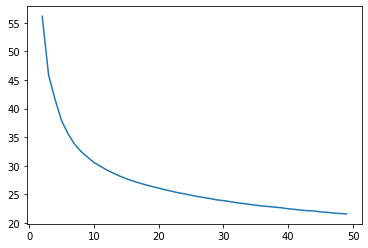

In [19]:

plt.plot(list(range(2,maxRange)),inert)


Text(0, 0.5, 'Silhoutte Score')

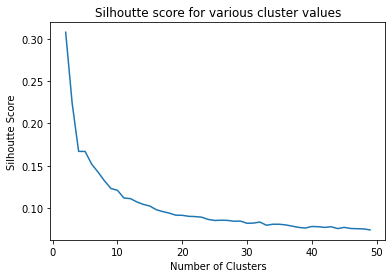

In [20]:
plt.plot(list(range(2,maxRange)),sil)
plt.title("Silhoutte score for various cluster values")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhoutte Score")

Silhoutte Score 0.12082854


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


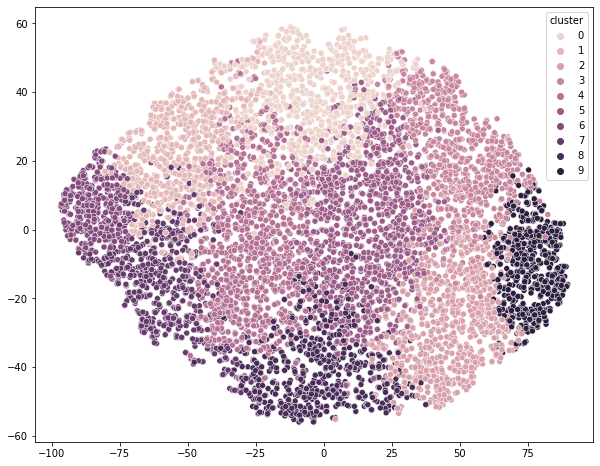

In [21]:
model = KMeans(n_clusters=10, random_state=10)
cluster_labels = model.fit_predict(X)
silhouette_avg = silhouette_score(X, cluster_labels)
print("Silhoutte Score",silhouette_avg)
netflix_titles['cluster'] = cluster_labels

tsne = TSNE(n_components=2)
tsne_mat = tsne.fit_transform(X)
plt.figure(figsize=(10,8))
sns.scatterplot(tsne_mat[:,0],tsne_mat[:,1],hue=netflix_titles['cluster'],legend = 'full')

### **Implementing K means clustering using AutoEncoder Feature Extraction**

In [22]:
## maximum features to keep (based on frequency)
max_features = 10000
## stop words were already removed before
vectorizer = CountVectorizer(max_features = max_features)
vectorizer.fit(netflix_titles['description']) 
review_vectors = vectorizer.transform(netflix_titles['description']) 
review_train = review_vectors.toarray() 
scaler = MinMaxScaler() 
review_train = scaler.fit_transform(review_train)
print(review_train.shape)

(8807, 10000)


In [23]:
## define the encoder
inputs_dim = review_train.shape[1]
encoder = Input(shape = (inputs_dim, ))
e = Dense(4096, activation = "relu")(encoder)
e = Dense(1024, activation = "relu")(e)
e = Dense(256, activation = "relu")(e)
e = Dense(128, activation = "relu")(e)
## bottleneck layer
n_bottleneck = 10
## defining it with a name to extract it later
bottleneck_layer = "bottleneck_layer"
# can also be defined with an activation function, relu for instance
bottleneck = Dense(n_bottleneck, name = bottleneck_layer)(e)
## define the decoder (in reverse)
decoder = Dense(128, activation = "relu")(bottleneck)
decoder = Dense(256, activation = "relu")(decoder)
decoder = Dense(512, activation = "relu")(decoder)
decoder = Dense(1024, activation = "relu")(decoder)
decoder = Dense(2048, activation = "relu")(decoder)
decoder = Dense(4096, activation = "relu")(decoder)
## output layer
output = Dense(inputs_dim)(decoder)
## model
model = Model(inputs = encoder, outputs = output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10000)]           0         
                                                                 
 dense (Dense)               (None, 4096)              40964096  
                                                                 
 dense_1 (Dense)             (None, 1024)              4195328   
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 bottleneck_layer (Dense)    (None, 10)                1290      
                                                                 
 dense_4 (Dense)             (None, 128)               1408  

In [24]:
#compiling model
encoder = Model(inputs = model.input, outputs = bottleneck)

model.compile(loss = "mse", optimizer = "adam")
history = model.fit(
    review_train,
    review_train,
    batch_size = 256,
    epochs = 10,
    verbose = 1
)

Epoch 1/10
35/35 [==============================] - 107s 3s/step - loss: 0.0011
Epoch 2/10
35/35 [==============================] - 106s 3s/step - loss: 0.0011
Epoch 3/10
35/35 [==============================] - 108s 3s/step - loss: 0.0011
Epoch 4/10
35/35 [==============================] - 111s 3s/step - loss: 0.0011
Epoch 5/10
35/35 [==============================] - 109s 3s/step - loss: 0.0011
Epoch 6/10
35/35 [==============================] - 109s 3s/step - loss: 0.0011
Epoch 7/10
35/35 [==============================] - 109s 3s/step - loss: 0.0011
Epoch 8/10
35/35 [==============================] - 109s 3s/step - loss: 0.0011
Epoch 9/10
35/35 [==============================] - 108s 3s/step - loss: 0.0011
Epoch 10/10
35/35 [==============================] - 109s 3s/step - loss: 0.0011


In [25]:
#encoding using auto encoder
review_encoded = encoder.predict(review_train)
review_encoded.shape

(8807, 10)

### Tuning for K Value

In [26]:
inert = []
sil = []
for k in range(2,maxRange):
    model = KMeans(n_clusters=k, random_state=10)
    cluster_labels = model.fit_predict(review_encoded)
    silhouette_avg = silhouette_score(review_encoded, cluster_labels)
    inertia = model.inertia_
    sil.append(silhouette_avg)
    inert.append(inertia)

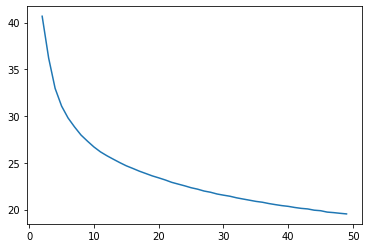

In [27]:
plt.plot(list(range(2,maxRange)),inert)


Text(0, 0.5, 'Silhoutte Score')

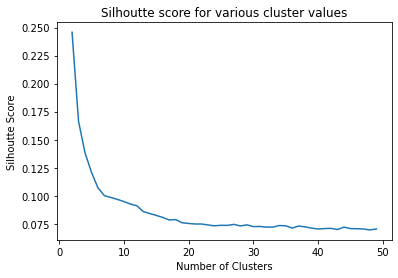

In [28]:
plt.plot(list(range(2,maxRange)),sil)
plt.title("Silhoutte score for various cluster values")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhoutte Score")

Silhoutte Score:  0.09479461


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


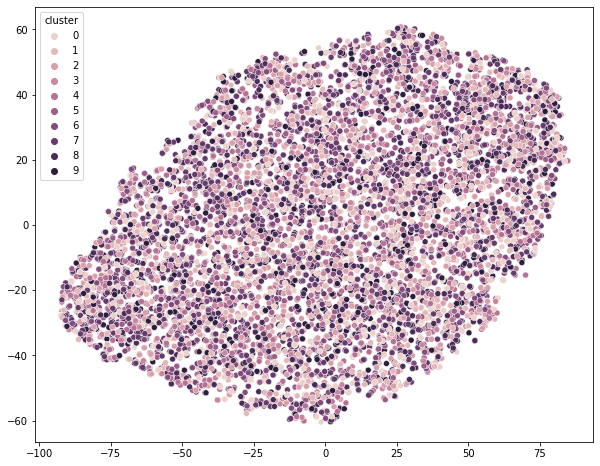

In [29]:
model = KMeans(n_clusters=10, random_state=10)
cluster_labels = model.fit_predict(review_encoded)
silhouette_avg = silhouette_score(review_encoded, cluster_labels)
print('Silhoutte Score: ', silhouette_avg )
netflix_titles['cluster'] = cluster_labels

tsne = TSNE(n_components=2)
tsne_mat = tsne.fit_transform(X)
plt.figure(figsize=(10,8))
sns.scatterplot(tsne_mat[:,0],tsne_mat[:,1],hue=netflix_titles['cluster'],legend = 'full')

In [30]:
netflix_titles['cluster'].value_counts()

7    1323
6    1064
0    1037
2     988
4     969
1     967
8     953
9     681
5     434
3     391
Name: cluster, dtype: int64